In [1]:
import os
directory = f'/Users/lilimatic/greenspace'
os.chdir(directory)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import tree
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import matplotlib.pyplot as plt


In [2]:
from functions.ml_data_hot_one import *

df_copy = df.copy()

/Users/lilimatic/greenspace/functions/ml_data_hot_one.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.safety[df[df.physicalsafety != df.covidsafety].index] = 0
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [3]:
#df.plot(x='safety',y=df.safety,kind='bar')

In [4]:
sum(df.safety)/len(df.safety)

0.45

In [5]:
y = 'safety'

X_train, X_test, y_train, y_test = train_test_split(df_copy.loc[:, df_copy.columns != y], \
                                                    df_copy[y], test_size=0.25)

In [6]:
#Similar proportions
sum(y_test)/len(y_test)

0.42

In [7]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)


rf = RandomForestClassifier(n_estimators=15,max_depth=8,random_state=24,criterion='gini',min_samples_split=10)

xgb = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1e-4, objective='binary:logistic')





In [8]:
#Model fit 

rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=8, min_samples_split=10, n_estimators=15,
                       random_state=24)

In [9]:

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
print('Training accuracy: ', np.mean(rf.predict(X_train) ==y_train)*100) 
print ('Test accuracy:', np.mean(rf.predict(X_test) ==y_test)*100)

Training accuracy:  85.0
Test accuracy: 71.0


In [11]:
print('Training accuracy: ', np.mean(xgb.predict(X_train) ==y_train)*100) 
print ('Test accuracy:', np.mean(xgb.predict(X_test) ==y_test)*100)

Training accuracy:  54.0
Test accuracy: 57.99999999999999


In [12]:
#plot_confusion_matrix(model,X_test,y_test,values_format='d',display_labels=['Safe','Unsafe'])

In [13]:
pred_prob1 = xgb.predict_proba(X_test)
pred_prob3 = rf.predict_proba(X_test)

In [14]:
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

In [15]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [16]:
# auc scores

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score3)

0.7809934318555007 0.7721674876847291


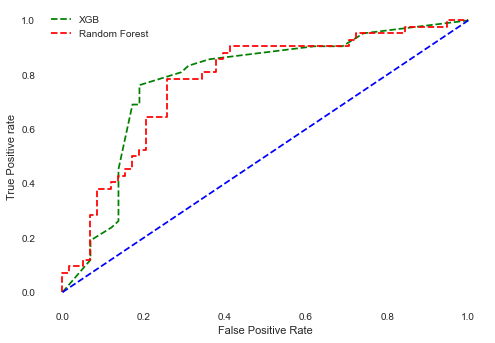

In [34]:


plt.style.use('seaborn')
plt.axes(facecolor='white')
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='green',label='XGB') #XGB
plt.plot(fpr3, tpr3, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)


#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [18]:
rf.score(X_test,y_test)

0.71

In [19]:
xgb.score(X_test,y_test)

0.58

In [20]:
y_pred = rf.predict(X_test)

In [21]:
cm = confusion_matrix(y_test,y_pred)

cm

array([[46, 12],
       [17, 25]])

In [22]:
rf.feature_importances_

array([0.06159327, 0.09159551, 0.02004715, 0.01376851, 0.02081443,
       0.01522496, 0.02221884, 0.00479307, 0.01562757, 0.02594293,
       0.01885391, 0.01626923, 0.01817357, 0.0260329 , 0.01342715,
       0.15546798, 0.04067058, 0.04124488, 0.01836214, 0.0255923 ,
       0.03768839, 0.01792613, 0.        , 0.01881398, 0.        ,
       0.02786946, 0.00765779, 0.02934703, 0.02759635, 0.04755685,
       0.02762164, 0.0196267 , 0.02883786, 0.01085103, 0.03288591])

In [23]:
accuracy_score(y_pred ,y_test)

0.71

In [24]:
cross_val_score(rf, X_train,y_train,cv=5)

array([0.66666667, 0.7       , 0.65      , 0.6       , 0.65      ])

In [25]:

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76        63
           1       0.60      0.68      0.63        37

    accuracy                           0.71       100
   macro avg       0.69      0.70      0.70       100
weighted avg       0.72      0.71      0.71       100



In [26]:
features = df.columns

importances = rf.feature_importances_
indices = np.argsort(importances)

values = list(rf.feature_importances_[indices])

names = [features[i] for i in indices]

importance = pd.DataFrame({'district' : names, 'importance': values})

importance = importance.sort_values('district')

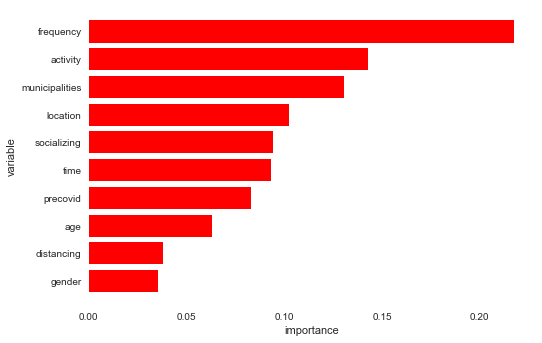

In [27]:
#merged will be summed 
merged = [] 
names_merged=[] 
for o in oldcolumns:
    if (len([col for col in df if col.startswith(o+'_')])>0):
        merged.append([col for col in df if col.startswith(o+'_')])
        names_merged.append(o)


sums_merged = []

for m in merged:
    #print(m)
    sums_merged.append(importance.loc[importance['district'].isin(m)].sum()[1])

names_merged.extend(['municipalities','activity','socializing','age','time'])

for x in [list_municipalities,list_activities,list_socializing]: 
    sums_merged.append(importance.loc[importance['district'].isin(list(x.columns))].sum()[1])
    
sums_merged.extend([importance.loc[importance['district'].isin(['age'])]['importance'].iloc[0],
importance.loc[importance['district'].isin(['time'])]['importance'].iloc[0]])

#remove effect of safety variable
sums_merged= sums_merged/sum(sums_merged)

important = pd.DataFrame({'variable': names_merged,'importance':sums_merged })

important = important.sort_values('importance')

#important.plot.bar(x='variable',y='importance',rot=0)

plt.axes(facecolor='white')
plt.barh(important.variable,important.importance,color='red')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

#ax.set_facecolor('white')

plt.savefig(f'/Users/lilimatic/greenspace/images/machine learning/importance_rf.png',transparent=True)


In [28]:
features = df.columns

importances = xgb.feature_importances_
indices = np.argsort(importances)

values = list(xgb.feature_importances_[indices])

names = [features[i] for i in indices]

importance = pd.DataFrame({'district' : names, 'importance': values})

importance = importance.sort_values('district')

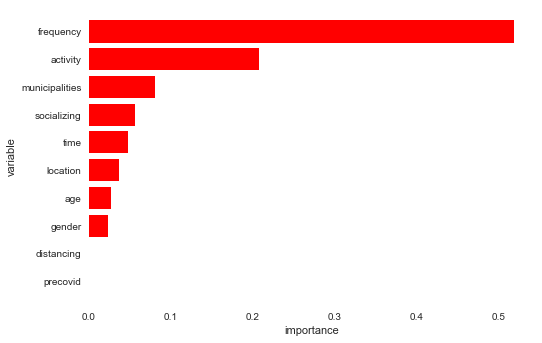

In [29]:
#merged will be summed 
merged = [] 
names_merged=[] 
for o in oldcolumns:
    if (len([col for col in df if col.startswith(o+'_')])>0):
        merged.append([col for col in df if col.startswith(o+'_')])
        names_merged.append(o)


sums_merged = []

for m in merged:
    #print(m)
    sums_merged.append(importance.loc[importance['district'].isin(m)].sum()[1])

names_merged.extend(['municipalities','activity','socializing','age','time'])

for x in [list_municipalities,list_activities,list_socializing]: 
    sums_merged.append(importance.loc[importance['district'].isin(list(x.columns))].sum()[1])
    
sums_merged.extend([importance.loc[importance['district'].isin(['age'])]['importance'].iloc[0],
importance.loc[importance['district'].isin(['time'])]['importance'].iloc[0]])

#remove effect of safety variable
sums_merged= sums_merged/sum(sums_merged)

important = pd.DataFrame({'variable': names_merged,'importance':sums_merged })

important = important.sort_values('importance')

#important.plot.bar(x='variable',y='importance',rot=0)

plt.axes(facecolor='white')
plt.barh(important.variable,important.importance,color='red')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

#ax.set_facecolor('white')

plt.savefig(f'/Users/lilimatic/greenspace/images/machine learning/importance_xgb.png',transparent=True)


In [30]:
fn=X_train.columns
cn=['safe','unsafe']

In [31]:
cn

['safe', 'unsafe']

In [41]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,10), dpi=900)

tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               max_depth =2,
               filled = True, fontsize=10);
plt.savefig(f'/Users/lilimatic/greenspace/images/machine learning/rf_individualtree.png')

